## Traffic Light Classifier - Evaluation

Notebook to evaluate the pretrained models in https://github.com/ThomasHenckel/CarND-Capstone/tree/master/Traffic_Light_Detection

In [1]:
!pip install tqdm
!pip install lxml
!pip install sklearn

    100% |████████████████████████████████| 51kB 1.6MB/s ta 0:00:01
    100% |████████████████████████████████| 5.6MB 156kB/s eta 0:00:01
    100% |████████████████████████████████| 5.5MB 158kB/s eta 0:00:01
    100% |████████████████████████████████| 24.8MB 39kB/s  eta 0:00:01
    100% |████████████████████████████████| 17.0MB 57kB/s  eta 0:00:01


In [1]:
import numpy as np
import os
import tensorflow as tf
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import glob
import random
import time
from tqdm import tqdm_notebook
from lxml import etree
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

%matplotlib inline

In [2]:
import tensorflow as tf
tf.__version__

'1.12.0'

In [3]:
# Check version of Tensorflow installed
!pip list | grep tensorflow

DEPRECATION: The default format will switch to columns in the future. You can use --format=(legacy|columns) (or define a format=(legacy|columns) in your pip.conf under the [list] section) to disable this warning.
tensorflow-gpu (1.11.0)


In [4]:
def load_model(file_path):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(file_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph
            
def load_image(image_path):
    image = Image.open(image_path)
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def run_inference(sess, ops, image_tensor, image):
    output_dict = {}
    
    time_s = time.time()
    num_detections, boxes, scores, classes = sess.run(ops, feed_dict={image_tensor: image})
    time_t = time.time() - time_s
    
    output_dict['num_detections'] = int(num_detections[0])
    output_dict['detection_classes'] = classes[0].astype(np.uint8)
    output_dict['detection_boxes'] = boxes[0]
    output_dict['detection_scores'] = scores[0]
    output_dict['detection_time'] = time_t
    
    return output_dict

In [5]:
def extract_class(detection_dict, threshold = 0.5):
    detection_classes = detection_dict['detection_classes']
    detection_scores = detection_dict['detection_scores']
    if detection_scores[0] >= threshold:
        return detection_classes[0]
    return 0

def load_labels(image_paths, labels_dir, label_map):
    labels = []
    for image_path in image_paths:
        file_name = os.path.splitext(os.path.basename(image_path))[0]
        image_label = os.path.join(labels_dir, file_name + '.xml')
        image_class = 0 # Fake class for "background" images without traffic lights

        if os.path.isfile(image_label):
            with tf.gfile.GFile(image_label, 'r') as f:
                xml = f.read()
            xml = etree.fromstring(xml)
            object_el = next(xml.iter('object'), None)
            if object_el is not None:
                class_name = next(object_el.iter('name')).text
                image_class = label_map[class_name]

        labels.append(image_class)
    return labels

def evaluate(name, graph, image_paths, labels, cpu = False):
    
    predictions = []
    
    with graph.as_default():
    
        image_tensor = graph.get_tensor_by_name('image_tensor:0')
        boxes_tensor = graph.get_tensor_by_name('detection_boxes:0')
        scores_tensor = graph.get_tensor_by_name('detection_scores:0')
        classes_tensor = graph.get_tensor_by_name('detection_classes:0')
        detections_tensor = graph.get_tensor_by_name('num_detections:0')

        ops = [detections_tensor, boxes_tensor, scores_tensor, classes_tensor]
        
        config = None
        
        if cpu:
            config = tf.ConfigProto(device_count = {'GPU': 0})

        with tf.Session(config=config) as sess:
            
            if len(image_paths) > 0:
                # Preload
                image = load_image(image_paths[0])
                run_inference(sess, ops, image_tensor, np.expand_dims(image, axis=0))
            
            time_t = 0
            for image_path in tqdm_notebook(image_paths, desc='{}'.format(name), unit=' images'):
                image = load_image(image_path)
                # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                image = np.expand_dims(image, axis=0)
                # Actual detection.
                output_dict = run_inference(sess, ops, image_tensor, image)
                time_t += output_dict['detection_time']
                prediction = extract_class(output_dict)
                predictions.append(prediction)
                
    for i, (label, prediction) in enumerate(zip(labels, predictions)):
        if label != prediction:
            print('Image misclassified: {} (Expected: {}, Predicted: {})'.format(image_paths[i], label, prediction))
                
    accuracy = accuracy_score(labels, predictions)
    
    return accuracy, time_t * 1000

In [6]:
LABELS_MAP_PATH = os.path.join('..', 'config', 'labels_map.pbtxt')
LABELS_MAP = {'Green': 1, 'Yellow': 2, 'Red': 3}

def evaluate_models(models_dir, data_dir, models, model_file = 'frozen_inference_graph.pb', n_samples = None, cpu = False):
    image_paths = glob.glob(os.path.join(data_dir, '*.jpg'))
    labels = load_labels(image_paths, os.path.join(data_dir, 'labels'), LABELS_MAP)
    image_paths, labels = shuffle(image_paths, labels, n_samples = n_samples)
    
    for model_name in models:
        model_path = os.path.join(models_dir, model_name, model_file)
        graph = load_model(model_path)
        accuracy, total_time = evaluate(model_name, graph, image_paths, labels, cpu = cpu)
        avg_time = total_time / len(image_paths)
        fps = 1000 / avg_time
        print('Model {} Accuracy: {:.3f} (Avg Time: {:.3f} ms, FPS: {:.3f})'.format(model_name, accuracy, avg_time, fps))

# Evaluate Accuracy
Accuracy is evaluated on the carla test set that was excluded from the model train/test set.
To make sure that the TF v 1.4.0 version of the model works the same we run the evaluation on both

In [13]:
MODELS_DIR = os.path.join('..', 'models', 'converted_to_TFv14')
DATA_DIR = os.path.join('..', 'test_images/carla_testing')   #'data', 'simulator')

n_samples = 1011

models = ['ssd_mobilenet_v2']

evaluate_models(MODELS_DIR, DATA_DIR, models, n_samples = n_samples, cpu = False)

AttributeError: 'function' object has no attribute 'glob'

In [19]:
MODELS_DIR = os.path.join('..', 'models', 'exported')
DATA_DIR = os.path.join('..', 'test/carla_testing')   #'data', 'simulator')

n_samples = 1011

models = ['ssd_mobilenet_v2']

evaluate_models(MODELS_DIR, DATA_DIR, models, n_samples = n_samples, cpu = False)


Image misclassified: ../test/carla_testing/uda_2_r_0014.jpg (Expected: 3, Predicted: 0)
Image misclassified: ../test/carla_testing/uda_2_u_0610.jpg (Expected: 0, Predicted: 1)
Image misclassified: ../test/carla_testing/uda_2_r_0002.jpg (Expected: 3, Predicted: 0)
Image misclassified: ../test/carla_testing/uda_2_u_0369.jpg (Expected: 0, Predicted: 1)
Image misclassified: ../test/carla_testing/uda_2_r_0099.jpg (Expected: 3, Predicted: 0)
Image misclassified: ../test/carla_testing/uda_2_u_0613.jpg (Expected: 0, Predicted: 1)
Image misclassified: ../test/carla_testing/uda_2_r_0013.jpg (Expected: 3, Predicted: 0)
Image misclassified: ../test/carla_testing/uda_2_r_0006.jpg (Expected: 3, Predicted: 0)
Image misclassified: ../test/carla_testing/uda_2_u_0385.jpg (Expected: 0, Predicted: 1)
Image misclassified: ../test/carla_testing/uda_2_u_0606.jpg (Expected: 0, Predicted: 1)
Image misclassified: ../test/carla_testing/uda_2_r_0102.jpg (Expected: 3, Predicted: 0)
Image misclassified: ../test/ca

## Detection and save test images

In [7]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

/mnt/d/the_workspace/models/research/object_detection/utils/visualization_utils.py:25: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements


In [8]:
MODELS_DIR = os.path.join('..', 'models', 'converted_to_TFv14') #'exported')
model_file = 'ssd_mobilenet_v2/frozen_inference_graph.pb' #'ssd_mobilenet/frozen_inference_graph.pb'

MODEL_PATH = os.path.join(MODELS_DIR, model_file)
LABELS_MAP_PATH = os.path.join('..', 'config', 'labels_map.pbtxt') #PATH_TO_LABELS = 'labels_map.pbtxt'

NUM_CLASSES = 3

### Loadig label map


In [9]:
label_map = label_map_util.load_labelmap(LABELS_MAP_PATH)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Yellow'}, 3: {'id': 3, 'name': 'Red'}}


In [10]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)
from glob import glob

### Detection

In [11]:
DATA_DIR = os.path.join('..', 'test_images') 

print(os.path.join(DATA_DIR, '*.jpg'))
DATA_PATHS = glob(os.path.join(DATA_DIR, '*.jpg'))
print("Length of test images:", len(DATA_PATHS))

# Size, in inches, of the output images. (original size: 350, 280)
IMAGE_SIZE = (10, 8) 

../test_images/*.jpg
Length of test images: 13


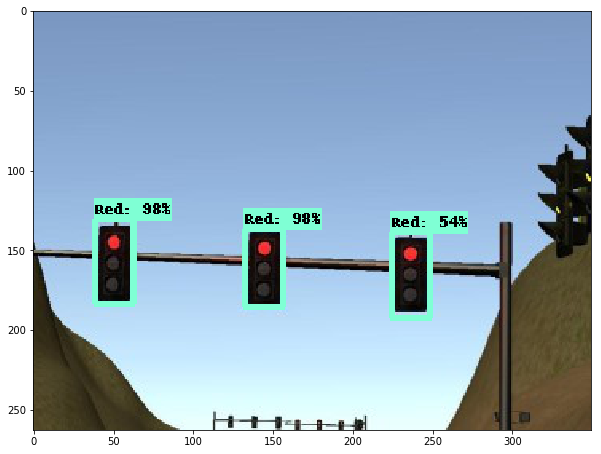

Red 0.988735
Time in milliseconds 947.9432106018066 

Red 0.9879682
Time in milliseconds 947.9432106018066 

Red 0.5401042
Time in milliseconds 947.9432106018066 



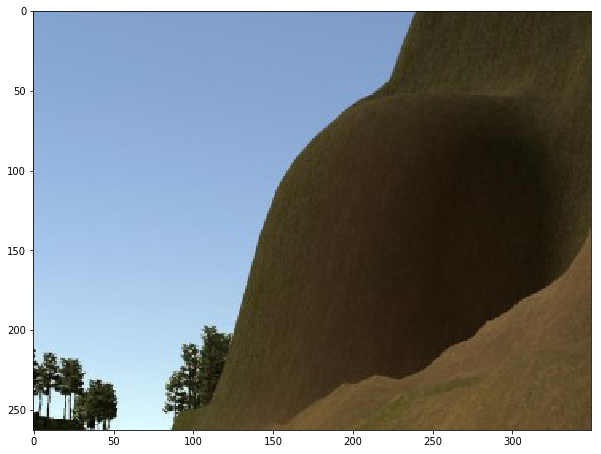

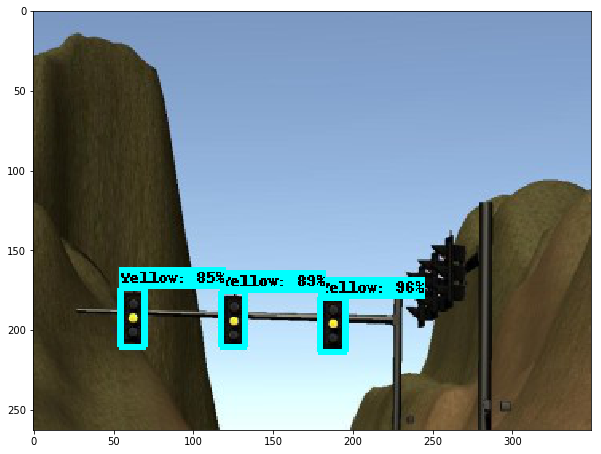

Yellow 0.9641966
Time in milliseconds 36.078453063964844 

Yellow 0.8903995
Time in milliseconds 36.078453063964844 

Yellow 0.8501112
Time in milliseconds 36.078453063964844 



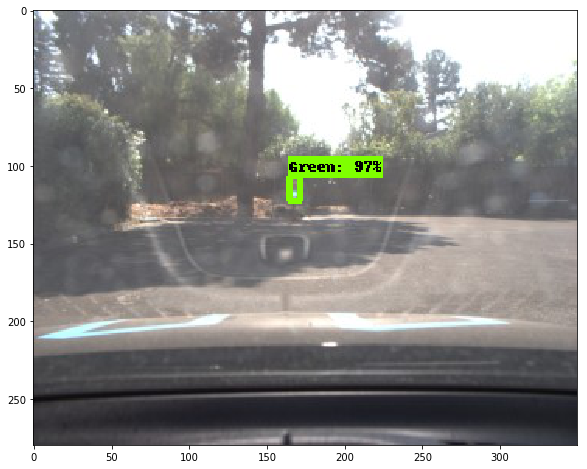

Green 0.97793394
Time in milliseconds 37.51063346862793 



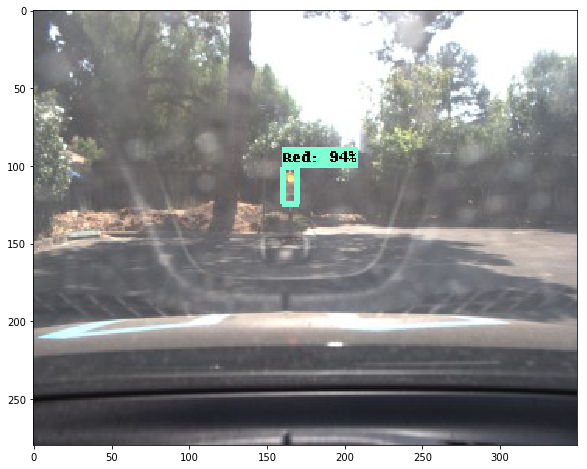

Red 0.94179946
Time in milliseconds 36.86976432800293 



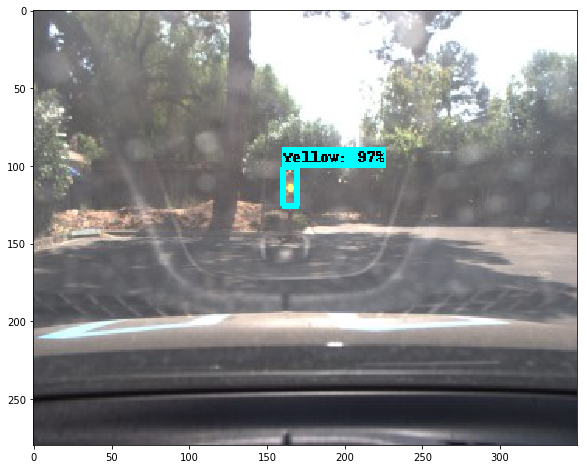

Yellow 0.9716053
Time in milliseconds 34.70182418823242 



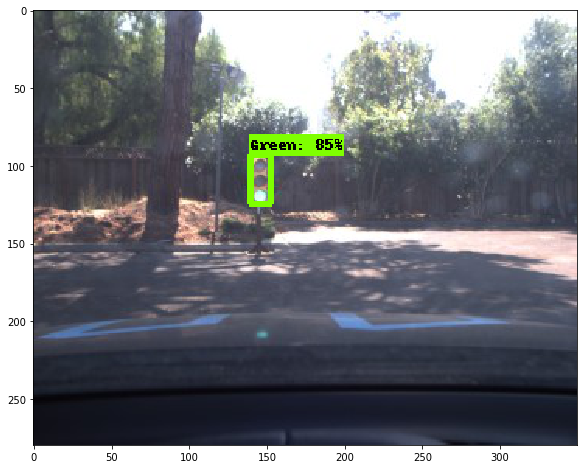

Green 0.85264784
Time in milliseconds 35.50148010253906 



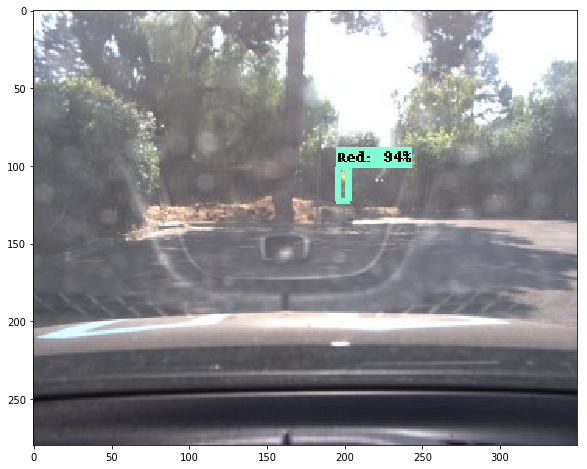

Red 0.9498638
Time in milliseconds 35.96901893615723 



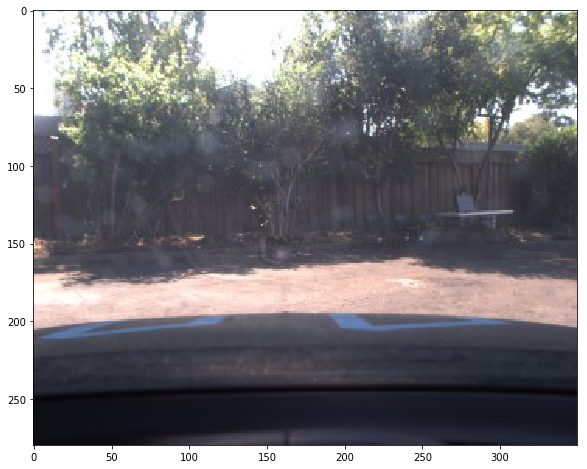

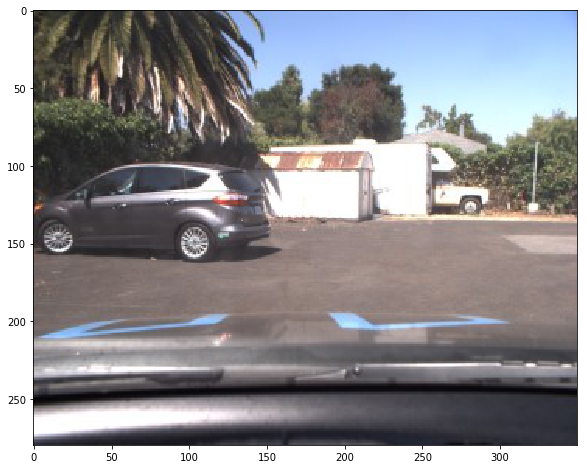

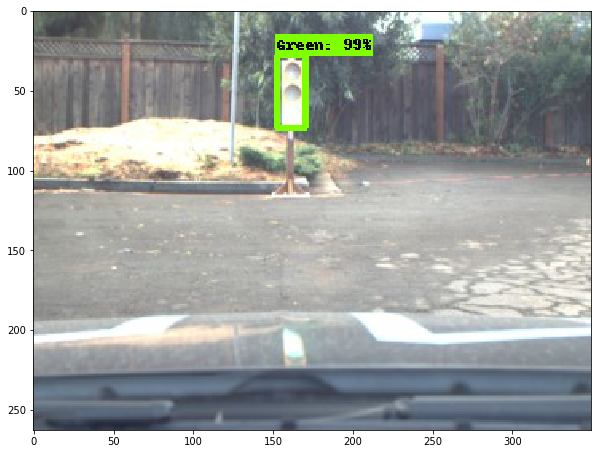

Green 0.99842983
Time in milliseconds 35.6442928314209 



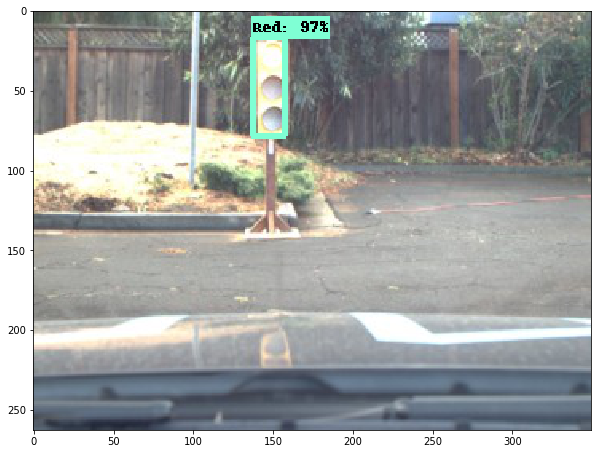

Red 0.9741512
Time in milliseconds 39.908647537231445 



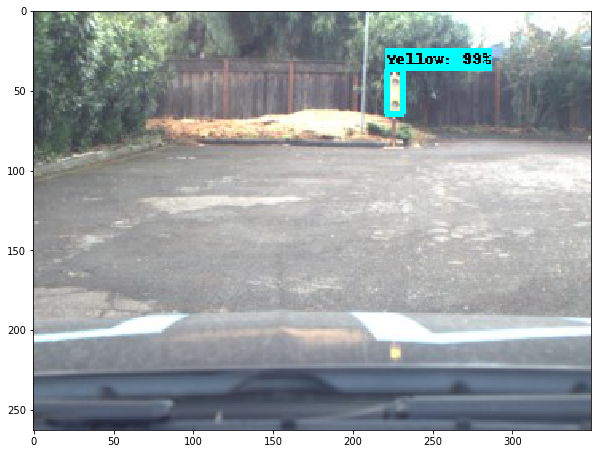

Yellow 0.99406636
Time in milliseconds 35.30478477478027 



In [12]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    od_graph_def = tf.GraphDef()

    with tf.gfile.GFile(MODEL_PATH, 'rb') as fid:
        
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in DATA_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=4)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()
            
            im = Image.fromarray(image_np)
            im.save("../test_images_result/"+image_path.split('/')[-1].split(".")[0]+"_result.jpg", "JPEG", quality=80, optimize=True, progressive=True)


            min_score_thresh = .30
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n")